# 欺诈风险账户识别项目大纲
1. 项目简介
2. 环境配置
3. 数据处理
4. 特征工程
5. 模型构建
6. 性能评估




## 项目简介

### 项目来源
[DCIC2023-科技金融应用：欺诈风险识别](https://www.dcic-china.com/competitions/10060)

### 背景介绍
    近年来，跨境赌博、电信网络诈骗、黑产等外部欺诈违法犯罪形势日益严峻，同时，监管机构要求各家银行开发和运用有效的金融科技和大数据系统，分析涉赌涉诈资金交易新方式，总结资金风险新特征，持续优化风险监测模型，全面排查存量风险。于2022年12月正式施行的《中华人民共和国反电信网络诈骗法》把反欺诈工作上升到了法律层面。该法案亦指出，银行业金融机构应当建立完善符合电信网络诈骗活动特征的异常账户和可疑交易的监测机制。

### 目标任务
    本赛题旨在运用有效的金融科技和大数据系统，分析涉赌涉诈资金交易新方式，持续优化风险监测模型，通过赛题提供的涉赌涉诈黑名单、白名单及用于训练的相关交易流水数据集，构建涉赌涉诈账户算法识别模型，全面排查存量风险。

## 环境配置

### 安装所需工具包
该项目需要提前在自己的python环境中安装好一下工具包：
* numpy
* pandas
* matplotlib
* seaborn: `pip install seaborn`
* sklearn: `pip install scikit-learn`
* scipy: `pip install scipy`
* xgboost: `pip install xgboost` or `pip install xgboost -i http://pypi.douban.com/simple --trusted-host pypi.douban.com`
* lightgbm: `pip install lightgbm` or `pip install lightgbm -i http://pypi.douban.com/simple --trusted-host pypi.douban.com`
* catboost: `pip install catboost` or `pip install catboost -i http://pypi.douban.com/simple --trusted-host pypi.douban.com`

(如果已经安装好了conda包管理工具，也可将上述指令中的`pip`替换成为`conda`)

In [60]:
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold,StratifiedShuffleSplit,train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import log_evaluation, early_stopping
from catboost import CatBoostClassifier
import scipy.signal as sg
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## 数据处理

### 数据集介绍
一共三个`.csv`文件：
* **‘账户交易信息.csv’**：单位是交易流水，包含了交易对方账户代号、交易金额、交易渠道、交易时间等信息
* **‘账户静态信息.csv’**：单位是账户，包含了账户代号、开户日期、开户人性别、开户人年龄等信息
* **‘训练集标签.csv’**：单位是账户，包含了账户代号和涉诈标签

In [10]:
#读入数据集
data_transa = pd.read_csv('data/账户交易信息.csv')
data_static = pd.read_csv('data/账户静态信息.csv')
data_label = pd.read_csv('data/训练集标签.csv')
data_transa.head()


,jylsxh,zhdh,dfzh,jdbj,jyje,zhye,dfhh,jyrq,jysj,jyqd,zydh,dfmccd
0,5D252156AE9F6B6595A1C56F56D4F91C,86C379D938234BAA,14BEFED1370B730A,0,310.00,57806.83,834E1F06,2020-03-01,00:18:06,E96ED478,4E0CB6FB,45
1,8BB3D82CA8E5F95577CA3E2DF432DF64,8EB373F073727157,FD7F11B33576339B,1,599.99,7099.73,B3D461D4,2020-03-01,00:18:17,621461AF,A3C65C29,6
2,412B7E903BC06882EEB9FB6A484D0773,997DED969A377D40,014F2782648E7FDA,1,4000.00,34448.04,A71C76B8,2020-03-01,00:18:30,621461AF,A3C65C29,6
3,F1122F893AC75DC8751190C67E1C3DB6,8EB373F073727157,129FAF9FD9D03346,1,299.98,7399.71,8A1BC467,2020-03-01,00:19:06,621461AF,A3C65C29,6
4,8BD9575EA55E67D4E99AC43B2A444172,8EB373F073727157,3B9CD92F13274EBA,1,999.96,8399.67,A8DA3378,2020-03-01,00:19:17,091D584F,2618045A,6


### 打印数据集基础信息，查看非空值条目

In [11]:
data_transa.info()
data_transa.isnull().any()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 816270 entries, 0 to 816269
Data columns (total 12 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   jylsxh  816270 non-null  object 
 1   zhdh    816270 non-null  object 
 2   dfzh    816270 non-null  object 
 3   jdbj    816270 non-null  int64  
 4   jyje    816270 non-null  float64
 5   zhye    816270 non-null  float64
 6   dfhh    816270 non-null  object 
 7   jyrq    816270 non-null  object 
 8   jysj    816270 non-null  object 
 9   jyqd    816270 non-null  object 
 10  zydh    816270 non-null  object 
 11  dfmccd  816270 non-null  int64  
dtypes: float64(2), int64(2), object(8)
memory usage: 74.7+ MB


jylsxh    False
zhdh      False
dfzh      False
jdbj      False
jyje      False
zhye      False
dfhh      False
jyrq      False
jysj      False
jyqd      False
zydh      False
dfmccd    False
dtype: bool

In [12]:
data_label[['zhdh','black_flag']]

,zhdh,black_flag
0,2029FF26D4E2CA79,0
1,09F5B90D46FB7CCE,1
2,E0C880EB18F4EFE8,1
3,ED8FFDCCF93C2F11,1
4,8D2F48B0BFC40AB2,1
...,...,...
1195,DF6B4ABA9EB3D2FA,1
1196,D3D68EBABD47D4AB,1
1197,E9652241DC476711,0
1198,5AD34DD10DEE0C9A,1


### 处理交易清单中交易金额为负数的项

In [13]:
#统计交易信息中交易金额为负的条目
neg_jyje_num = data_transa[data_transa['jyje'] < 0].shape[0]
neg_jyje_in_num = data_transa[data_transa['jyje'] < 0]['jdbj'].sum()
neg_jyje_out_num = neg_jyje_num - neg_jyje_in_num
print('{}笔入账负金额， {}笔出账负金额'.format(neg_jyje_in_num, neg_jyje_out_num))

1笔入账负金额， 2002笔出账负金额


In [14]:
#清理负的交易金额，变换对应的借贷标记
def clean_negative_jyje(_se : Series):
    _se['jyje'] *= -1
    _se['jdbj'] = 0 if _se['jdbj'] == 1 else 1
    return _se

In [15]:
#验证处理结果
pre_in_num = data_transa['jdbj'].sum()
data_transa[data_transa['jyje'] < 0] = data_transa[data_transa['jyje'] < 0].apply(clean_negative_jyje, axis=1)
after_in_num = data_transa['jdbj'].sum()
print(data_transa[data_transa['jyje'] < 0].shape[0])
# if  (after_in_num - pre_in_num) == (neg_jyje_out_num - neg_jyje_in_num):
#     print('处理正确...')
# else:
#     print('处理错误!!!')

print('处理正确...' if (after_in_num - pre_in_num) == (neg_jyje_out_num - neg_jyje_in_num) else \
      '处理错误!!!')

0
处理正确...


### 将账户的涉诈标记信息合并到交易流水信息和账户静态信息中，便于后续处理

In [16]:
# 将涉诈信息加入交易流水的各个条目
data_transa = pd.merge(data_transa, data_label, on='zhdh', how='left')
print(data_transa.head())

                             jylsxh              zhdh              dfzh  jdbj  \
0  5D252156AE9F6B6595A1C56F56D4F91C  86C379D938234BAA  14BEFED1370B730A     0   
1  8BB3D82CA8E5F95577CA3E2DF432DF64  8EB373F073727157  FD7F11B33576339B     1   
2  412B7E903BC06882EEB9FB6A484D0773  997DED969A377D40  014F2782648E7FDA     1   
3  F1122F893AC75DC8751190C67E1C3DB6  8EB373F073727157  129FAF9FD9D03346     1   
4  8BD9575EA55E67D4E99AC43B2A444172  8EB373F073727157  3B9CD92F13274EBA     1   

      jyje      zhye      dfhh        jyrq      jysj      jyqd      zydh  \
0   310.00  57806.83  834E1F06  2020-03-01  00:18:06  E96ED478  4E0CB6FB   
1   599.99   7099.73  B3D461D4  2020-03-01  00:18:17  621461AF  A3C65C29   
2  4000.00  34448.04  A71C76B8  2020-03-01  00:18:30  621461AF  A3C65C29   
3   299.98   7399.71  8A1BC467  2020-03-01  00:19:06  621461AF  A3C65C29   
4   999.96   8399.67  A8DA3378  2020-03-01  00:19:17  091D584F  2618045A   

   dfmccd  black_flag  
0      45         NaN  
1       

In [17]:
# 将设诈信息加入账户静态信息条目
data_static = pd.merge(data_static, data_label, on='zhdh', how='left')
print(data_static.head())

               zhdh        khrq    khjgdh  xb  nl  black_flag
0  DDF394282B1E1508  2018-04-13  577BCC91   1  25         NaN
1  CAE68290A37CC77D  2016-04-02  34ED066D   1  27         NaN
2  41E4A8AECE47E5F3  2014-09-28  30BB3825   1  44         NaN
3  163C42F2A3FD518E  2010-06-11  34ED066D   1  55         0.0
4  6FBFEB03252FDB9F  2015-08-20  D64A340B   0  44         NaN


### 查看各个表中的特定特征的基础信息

In [18]:
#查看data_transa中的训练部分数据
data_transa_train = data_transa[data_transa['black_flag'].notnull()]

#查看交易时间范围：
print('min_date:{}, max_date:{}'.format(data_transa_train['jyrq'].min(),data_transa_train['jyrq'].max()))
print('min_time:{}, max_time:{}'.format(data_transa_train['jysj'].min(),data_transa_train['jysj'].max()))
#查看整个交易清单中出现了多少种不同的交易渠道，摘要代号，对方行号
print('共{}种不同的交易渠道, {}种不同的摘要代号, {}种不同的行号'.format(data_transa_train[data_transa_train['black_flag'] == 1]['jyqd'].nunique(),data_transa_train[data_transa_train['black_flag'] == 1]['zydh'].nunique(), data_transa_train[data_transa_train['black_flag'] == 1]['dfhh'].nunique()))

#查看对方账户个数：
print('{}个不同的对方账户'.format(data_transa_train['dfzh'].nunique()))


min_date:2020-03-01, max_date:2020-05-31
min_time:00:00:02, max_time:23:59:57
共14种不同的交易渠道, 47种不同的摘要代号, 547种不同的行号
26197个不同的对方账户


## 特征工程
* 在原始数据基础上扩展数据，得到更多信息
* 构建合适的统计量(特征)
    * 基本统计量(特征)
    * 凭借经验和项目背景搭建特定统计量
    * 可视化分类标签不同的原始数据中相关变量的取值范围，分布等，从中挑选出潜在特征
* 以账户为单位处理原始数据信息得到对应特征的值，得到总特征
* 可视化总特征中各个特征之间的相关性以及其在不同类别单位上的分布情况，选择性的进行删除和修改


### 在原始的数据集上衍生更多有用信息

In [19]:
# 交易静态时间信息
col = 'jyts'
data_transa[col] = pd.to_datetime(data_transa['jyrq'] + ' ' + data_transa['jysj'])
data_transa['jyrq_month'] = data_transa[col].dt.month
data_transa['jyrq_day'] = data_transa[col].dt.day
data_transa['jyrq_hour'] = data_transa[col].dt.hour
data_transa['jyrq_dayofweek'] = data_transa[col].dt.dayofweek
data_transa['jyrq_dayofyear'] = data_transa[col].dt.dayofyear
data_transa['jyrq_hour_level'] = data_transa['jyrq_hour'] // 6 #代表的含义是该次交易出现在当天的哪个时间段内

In [20]:
data_transa.head()

,jylsxh,zhdh,dfzh,jdbj,jyje,zhye,dfhh,jyrq,jysj,jyqd,zydh,dfmccd,black_flag,jyts,jyrq_month,jyrq_day,jyrq_hour,jyrq_dayofweek,jyrq_dayofyear,jyrq_hour_level
0,5D252156AE9F6B6595A1C56F56D4F91C,86C379D938234BAA,14BEFED1370B730A,0,310.00,57806.83,834E1F06,2020-03-01,00:18:06,E96ED478,4E0CB6FB,45,NaN,2020-03-01 00:18:06,3,1,0,6,61,0
1,8BB3D82CA8E5F95577CA3E2DF432DF64,8EB373F073727157,FD7F11B33576339B,1,599.99,7099.73,B3D461D4,2020-03-01,00:18:17,621461AF,A3C65C29,6,NaN,2020-03-01 00:18:17,3,1,0,6,61,0
2,412B7E903BC06882EEB9FB6A484D0773,997DED969A377D40,014F2782648E7FDA,1,4000.00,34448.04,A71C76B8,2020-03-01,00:18:30,621461AF,A3C65C29,6,NaN,2020-03-01 00:18:30,3,1,0,6,61,0
3,F1122F893AC75DC8751190C67E1C3DB6,8EB373F073727157,129FAF9FD9D03346,1,299.98,7399.71,8A1BC467,2020-03-01,00:19:06,621461AF,A3C65C29,6,NaN,2020-03-01 00:19:06,3,1,0,6,61,0
4,8BD9575EA55E67D4E99AC43B2A444172,8EB373F073727157,3B9CD92F13274EBA,1,999.96,8399.67,A8DA3378,2020-03-01,00:19:17,091D584F,2618045A,6,NaN,2020-03-01 00:19:17,3,1,0,6,61,0


In [21]:
# 账户静态时间信息
data_static['khrq']  = pd.to_datetime(data_static['khrq'], format='%Y-%m-%d')
data_static['year']  = data_static['khrq'].dt.year
data_static['month'] = data_static['khrq'].dt.month
data_static['day']   = data_static['khrq'].dt.day

keep_cols = ['zhdh','xb', 'nl']

### 计算数值统计量(特征)
    思考：(诈骗者的账户可能具备的特点有哪些？)

诈骗账户可能也能进行更加细致的分类，因为往往诈骗是以团队为单位进行的，比如：
* 有的诈骗账户直接与正常用户进行交易，进行诈骗，这类账户的特点可能是总`交易数量多，交易频率时高时低，无周期性，涉及到账户对象多，存在短时间小额转出后收到更大额度的转账，存在集中转出，短时间内转出金额较小，转入金额较大`
* 有的诈骗账户可能是骗子用来转移行骗资产的中转账户，这类账户的特点可能是`交易频率相对稳定，交易行为存在周期性，交易对象比较固定，大部分的交易都只和小部分的账户对象进行，存在集中转入，集中转出，平均交易金额可能偏大，账户余额长期处于低水平状态`
* 有的诈骗账户可能是骗子最终用于存储行骗资产的金库账户，这类账户的特点可能是`大部分的交易都是转入，转出占比非常小，且交易对象比较固定(行为方式和正常用户很像，较难区分)`
    

#### 基础特征
* 交易金额：
    * 转入总金额
    * 转出总金额
    * 转入(出)总金额占比
    * 转入金额最大值、最小值、均值、中值等
* 交易次数
    * 总交易数量
    * 转入数量
    * 转出数量
    * 转入(出)数占比
* 交易对象
    * 给多少不同账户转过账
    * 收到过多少不同账户的转账
    * 转入交易对象数与转出交易对象比值
* 余额
    * 最大值、最小值、均值
* 交易渠道
    * 入(出)账使用过多少不同的渠道
* 摘要代号
    * 入(出)账使用过多少不同的摘要代号
* 交易天数
    

In [22]:
def get_statistic_feature_base(data_sample: DataFrame):
    
    feature_dict = {} 

    # 转入金额、转出金额、转入金额占比
    feature_dict['in_amt'] = data_sample[data_sample['jdbj'] == 1]['jyje'].sum() 
    feature_dict['out_amt'] = data_sample[data_sample['jdbj'] == 0]['jyje'].sum()
    feature_dict['in_amt_ratio'] = data_sample[data_sample['jdbj'] == 1]['jyje'].sum() / \
                            (data_sample[data_sample['jdbj'] == 1]['jyje'].sum() + data_sample[data_sample['jdbj'] == 0]['jyje'].sum())
    
    #单笔转入金额与转出金额的最大值、最小值、均值、中值
    feature_dict['in_amt_max'] = data_sample[data_sample['jdbj'] == 1]['jyje'].max() 
    feature_dict['out_amt_max'] = data_sample[data_sample['jdbj'] == 0]['jyje'].max()
    feature_dict['in_amt_min'] = data_sample[data_sample['jdbj'] == 1]['jyje'].min()
    feature_dict['out_amt_min'] = data_sample[data_sample['jdbj'] == 0]['jyje'].min()
    feature_dict['in_amt_mean'] = data_sample[data_sample['jdbj'] == 1]['jyje'].mean()
    feature_dict['out_amt_mean'] = data_sample[data_sample['jdbj'] == 0]['jyje'].mean()
    feature_dict['in_amt_median'] = data_sample[data_sample['jdbj'] == 1]['jyje'].median()
    feature_dict['out_amt_median'] = data_sample[data_sample['jdbj'] == 0]['jyje'].median()

    #总交易次数
    feature_dict['all_opt_cnt'] = data_sample.shape[0] 
    #转入次数、转出次数、转入次数占比     
    feature_dict['in_opt_cnt'] = data_sample['jdbj'].sum() 
    feature_dict['out_opt_cnt'] = data_sample.shape[0] - data_sample['jdbj'].sum()          
    feature_dict['in_opt_ratio'] = data_sample['jdbj'].sum() / data_sample.shape[0]      

    #转入人数、转出人数、转入人数占比
    feature_dict['in_user_cnt'] = data_sample[data_sample['jdbj'] == 1]['dfzh'].nunique() 
    feature_dict['out_user_cnt'] = data_sample[data_sample['jdbj'] == 0]['dfzh'].nunique()
    feature_dict['in_user_ratio'] = data_sample[data_sample['jdbj'] == 1]['dfzh'].nunique() / \
                            (data_sample[data_sample['jdbj'] == 1]['dfzh'].nunique() + data_sample[data_sample['jdbj'] == 0]['dfzh'].nunique())
    

    #余额最大值、最小值、均值
    feature_dict['zhye_max'] = data_sample['zhye'].max()  
    feature_dict['zhye_min'] = data_sample['zhye'].min()
    feature_dict['zhye_mean'] = data_sample['zhye'].mean()
    
    #交易渠道
    feature_dict['in_jyqd_cnt'] = data_sample[data_sample['jdbj'] == 1]['jyqd'].nunique()  
    feature_dict['out_jyqd_cnt'] = data_sample[data_sample['jdbj'] == 0]['jyqd'].nunique()

    #摘要代号
    feature_dict['in_zydh_cnt'] = data_sample[data_sample['jdbj'] == 1]['zydh'].nunique()   
    feature_dict['out_zydh_cnt'] = data_sample[data_sample['jdbj'] == 0]['zydh'].nunique()

    #交易天数
    feature_dict['date_cnt'] = data_sample['jyrq'].nunique() 

    #return pd.DataFrame([feature_dict])        ##pandas不能直接用字典构建DataFrame
    return feature_dict

### 进阶特征
* 是否该账户交易主要集中在几个个别用户上
    * 该账户给和他转入(出)账最频繁的账户转了少多次账，与总转账次数比值
* 单日交易金额情况
    * 单日转入(出)总金额的最大值、最小值、均值、中值
* 单日交易数量情况
    * 单日转入(出)数量最大值、均值
* 交易金额和账户余额的比值关系
    * 每笔交易余额与交易金额的比例的均值
* 该账户的余额一般处于什么样的水平
    * 每天账户余额的均值
* 账户交易频率如何，大概多长时间就会进行一次交易
* 账户交易是否和时间区段有关，比如周末的交易情况如何
    * 周末的交易数
    * 周末的交易数占总交易数的比值

In [23]:
def get_statistic_feature_time(data_sample: DataFrame):
    # 加入时间的概念，加入时间的限制
    feature_dict = {} 

    #给同一人转账数量的最大值
    feature_dict['in_df_cnt_max'] = data_sample[data_sample['jdbj'] == 1]['dfzh'].value_counts().max() 
    #收到同一人转账数量的最大值
    feature_dict['out_df_cnt_max'] = data_sample[data_sample['jdbj'] == 0]['dfzh'].value_counts().max()
    #每笔交易余额与交易金额的比例的均值 
    feature_dict['zhye_jyje_ratio_mean'] = (data_sample['zhye'] / data_sample['jyje']).mean() 

    #单日转入总金额的最大值、最小值、均值、中值
    feature_dict['in_amt_max_oneday'] = data_sample[data_sample['jdbj'] == 1].groupby('jyrq')['jyje'].sum().max()
    feature_dict['in_amt_min_oneday'] = data_sample[data_sample['jdbj'] == 1].groupby('jyrq')['jyje'].sum().min()
    feature_dict['in_amt_mean_oneday'] = data_sample[data_sample['jdbj'] == 1].groupby('jyrq')['jyje'].sum().mean()
    feature_dict['in_amt_median_oneday'] = data_sample[data_sample['jdbj'] == 1].groupby('jyrq')['jyje'].sum().median()
    #单日转出总金额的最大值、最小值、均值、中值
    feature_dict['out_amt_max_oneday'] = data_sample[data_sample['jdbj'] == 0].groupby('jyrq')['jyje'].sum().max()
    feature_dict['out_amt_min_oneday'] = data_sample[data_sample['jdbj'] == 0].groupby('jyrq')['jyje'].sum().min()
    feature_dict['out_amt_mean_oneday'] = data_sample[data_sample['jdbj'] == 0].groupby('jyrq')['jyje'].sum().mean()
    feature_dict['out_amt_median_oneday'] = data_sample[data_sample['jdbj'] == 0].groupby('jyrq')['jyje'].sum().median()

    #单日转入数量最大值、均值
    feature_dict['in_opt_cnt_max_oneday'] = data_sample[data_sample['jdbj'] == 1].groupby('jyrq').size().max()
    feature_dict['in_opt_cnt_mean_oneday'] = data_sample[data_sample['jdbj'] == 1].groupby('jyrq').size().mean()
    #单日转出数量最大值、均值
    feature_dict['out_opt_cnt_max_oneday'] = data_sample[data_sample['jdbj'] == 0].groupby('jyrq').size().max()
    feature_dict['out_opt_cnt_mean_oneday'] = data_sample[data_sample['jdbj'] == 0].groupby('jyrq').size().mean()

    #每天余额情况，账户每天的最晚的一笔交易作为当天的余额
    feature_dict['jyje_oneday_mean'] = data_sample.sort_values(by='jysj', ascending = False).groupby('jyrq').first()['zhye'].mean()
    
    #账户交易频率，总交易时间区段/总交易次数
    feature_dict['jy_frequency'] = (data_sample['jyts'].max() - data_sample['jyts'].min()).total_seconds() / 3600 \
                                        / data_sample.shape[0]
    
    #周末的交易数，周末的交易数占总交易数的比值
    feature_dict['opt_cnt_weekend'] = data_sample[~(data_sample['jyrq_dayofweek'].between(1, 5))].shape[0]
    feature_dict['ratio_opt_cnt_weekend'] = data_sample[~(data_sample['jyrq_dayofweek'].between(1, 5))].shape[0] / data_sample.shape[0]

    return feature_dict

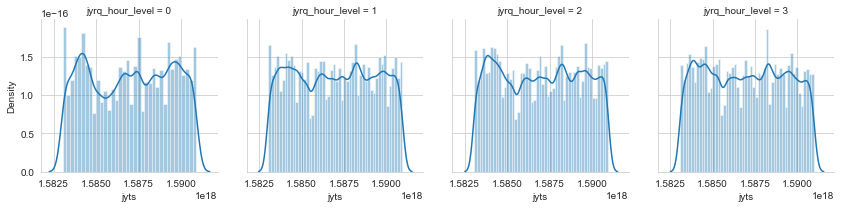

In [24]:
g = sns.FacetGrid(data_transa, col="jyrq_hour_level")
g.map(sns.distplot, 'jyts')

### 特殊特征
* 欺诈账户是否有可能集中使用一些特定的交易渠道(摘要代号)进行诈骗交易？
* 欺诈账户是否可能集中在一天的某个特定的时间段进行诈骗交易？
* 欺诈账户一周内每天的交易数量是否趋于稳定？
* 欺诈账户是否在月初和月末频繁进行交易？
* 欺诈账户的转账额度的分布如何？

In [25]:
# 获取特征col中出现次数最频繁的一些项的名称
def get_topk_names(colname: str, topk: int, _df: DataFrame) -> list :
    top_values = _df[colname].value_counts().reset_index()
    top_values.columns = [colname, 'num']
    top_values = top_values.sort_values('num', ascending=False) #降序排列
    top_names = top_values[colname].tolist()[0:topk]
    return top_names

#统计各个账户使用欺诈账户的topk_names进行交易的交易数目
def get_cnt_by_topk_names(_df: DataFrame, colname: str, top_names: list):
    feature_dict = {}
    for feat, name in zip(['{}_{}_cnt'.format(colname, n) for n in top_names],top_names):
        feature_dict[feat] = _df[_df[colname] == name].shape[0]
    return feature_dict

In [26]:
def get_statistic_feature_special(data_sample: DataFrame, topk_jyqd: list, topk_zydh: list):
    feature_dict = {} 

    #统计各个账户使用欺诈账户的topk个交易渠道进行交易的交易数目
    for feat, name in zip(['jyqd_{}_cnt'.format(n) for n in topk_jyqd], topk_jyqd):
        feature_dict[feat] = data_sample[data_sample['jyqd'] == name].shape[0]
    
    #统计各个账户使用欺诈账户的topk个摘要代号进行交易的交易数目
    for feat, name in zip(['zydh_{}_cnt'.format(n) for n in topk_zydh], topk_zydh):
        feature_dict[feat] = data_sample[data_sample['zydh'] == name].shape[0]


    #账户活跃度
    #把一天划分为4个时间段，经过可视化之后发现，欺骗账户在0时间段的交易数可能成为一项特征
    #feature_dict['ratio_jyrq_hour_1/0'] = data_sample[data_sample['jyrq_hour_level'] == 1].shape[0] / (data_sample[data_sample['jyrq_hour_level'] == 0].shape[0] + 1e-1)
    feature_dict['jyrq_hour_0_opt_cnt'] = data_sample[data_sample['jyrq_hour_level'] == 0].shape[0]
    #根据可视化结果，正常用户工作日的交易数量变化幅度很小，反观诈骗用户则不然，选取5个工作日的交易数量之间的方差作为特征
    tmp =  data_sample[data_sample['jyrq_dayofweek'].between(1, 5)].groupby('jyrq_dayofweek').size().reset_index()
    tmp.columns = ['jyrq_dayofweek', 'num']
    tmp_list = tmp['num'].to_list()
    feature_dict['workday_cnt_var'] = np.var(tmp_list) if len(tmp_list) != 0 else 0

    #3、4、5三个月的月初和月末的交易数
    total_num = 0
    for i in range(3,6):
        t = data_sample[data_sample['jyrq'].between('2020-0{}-01'.format(i), \
            '2020-0{}-05'.format(i)) | data_sample['jyrq'].between('2020-0{}-25'.format(i), '2020-0{}-31'.format(i))].shape[0]
        total_num += t
    feature_dict['opt_cnt_month_s&e'] = total_num

    #3、4、5三个月的月初和月末的交易额占总交易金额的比例
    total_amt = 0
    for i in range(3,6):
        t = data_sample[data_sample['jyrq'].between('2020-0{}-01'.format(i), \
            '2020-0{}-05'.format(i)) | data_sample['jyrq'].between('2020-0{}-25'.format(i), '2020-0{}-31'.format(i))]['jyje'].sum()
        total_amt += t
    feature_dict['jyje_amt_month_s&e'] = total_amt
    feature_dict['ratio_jyje_amt_month_s&e'] = total_amt / data_sample['jyje'].sum()

    #小额转账(入/出)次数和大额转账(入/出)次数之比
    in_data_sample = data_sample[data_sample["jdbj"] == 1]
    feature_dict['in_small_ratio'] = (in_data_sample["jyje"] < 100).sum() / ((in_data_sample["jyje"] >= 100).sum() + 1e-1)
    out_data_sample = data_sample[data_sample["jdbj"] == 0]
    feature_dict['out_small_ratio'] = (out_data_sample["jyje"] < 100).sum() / ((out_data_sample["jyje"] >= 100).sum() + 1e-1)
    feature_dict['small_ratio'] = (data_sample["jyje"] < 100).sum() / (data_sample["jyje"] >= 100).sum()

    return feature_dict

### 分析交易项的各种特征的区分度
* 连续特征：均值，方差，变异系数等
* 离散特征：概率分布等

In [27]:
fraud_jyslsum_name = data_transa[data_transa["black_flag"] == 1].groupby("jyrq").size().sort_values(ascending=False).index.tolist()[0:10]
print(fraud_jyslsum_name)
normal_jyslsum_name = data_transa[data_transa["black_flag"] == 0].groupby("jyrq").size().sort_values(ascending=False).index.tolist()[0:10]
print(normal_jyslsum_name)

['2020-05-26', '2020-05-25', '2020-05-05', '2020-05-04', '2020-05-06', '2020-04-27', '2020-04-30', '2020-03-04', '2020-03-20', '2020-04-29']
['2020-04-30', '2020-05-18', '2020-05-04', '2020-04-15', '2020-03-15', '2020-05-15', '2020-03-16', '2020-03-20', '2020-05-20', '2020-05-02']


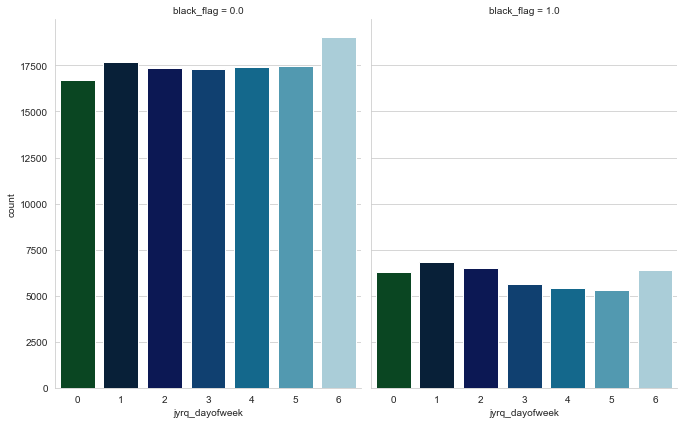

In [28]:
#sns.factorplot(x="jyrq_hour_level", data=data_transa, kind="count", col='black_flag', palette="ocean", size=6, aspect=0.8)
sns.factorplot(x="jyrq_dayofweek", data=data_transa, kind="count", col='black_flag', palette="ocean", size=6, aspect=0.8)
plt.show()

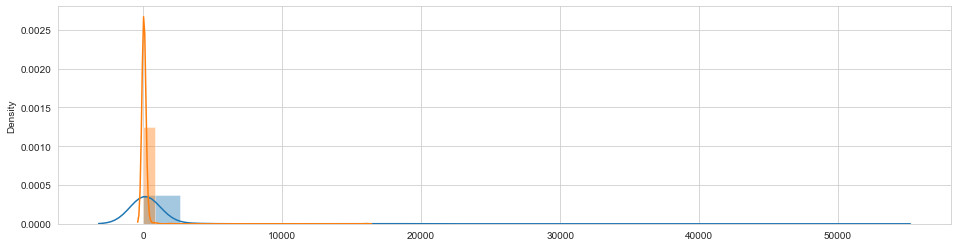

In [29]:
def get_workday_cnt_var(data_sample: DataFrame):
    feature_dict = {}
    t =  data_sample[data_sample['jyrq_dayofweek'].between(1, 5)].groupby('jyrq_dayofweek').size().reset_index()
    t.columns = ['jyrq_dayofweek', 'num']
    t_list = t['num'].to_list()
    feature_dict['workday_cnt_var'] = np.var(t_list) if len(t_list) != 0 else 0
    return pd.DataFrame([feature_dict])       

t1 = data_transa[data_transa['black_flag'] == 1].groupby('zhdh').apply(get_workday_cnt_var)
t2 = data_transa[data_transa['black_flag'] == 0].groupby('zhdh').apply(get_workday_cnt_var)
plt.figure(figsize=(16, 4))
sns.distplot(t1, bins=20)
sns.distplot(t2, bins=20)
plt.show()

In [30]:
##验证一下上述结果是否正确

# time_line = ['2020-03-01','2020-03-02','2020-03-03','2020-03-04','2020-03-05','2020-03-25','2020-03-26','2020-03-27','2020-03-28','2020-03-29','2020-03-30','2020-03-31',
#              '2020-04-01','2020-04-02','2020-04-03','2020-04-04','2020-04-05','2020-04-25','2020-04-26','2020-04-27','2020-04-28','2020-04-29','2020-04-30',
#              '2020-05-01','2020-05-02','2020-05-03','2020-05-04','2020-05-05','2020-05-25','2020-05-26','2020-05-27','2020-05-28','2020-05-29','2020-05-30','2020-05-31']

# time_line = []
# for i in range(3,6):
#     for j in range(1,6):
#         time_line.append('2020-0{}-0{}'.format(i, j))
#     for j in range(25,32):
#         time_line.append('2020-0{}-{}'.format(i, j))

# d_sample = data_transa[data_transa['zhdh'] == '00037295453A928A']
# cnt = d_sample[d_sample['jyrq'].isin(time_line)].shape[0]
# amt = d_sample[d_sample['jyrq'].isin(time_line)]['jyje'].sum()
# print(cnt, amt)

### 搭建总特征
* 为什么不做特征归一化操作：
    * 归一化主要针对的是连续特征，目的是为了避免梯度下降时等高线是椭圆而导致的迭代次数增多的问题
    * 类似xgboost这样的数模型不可导，无法进行梯度下降
    * 树模型是通过寻找特征的最优分裂点来完成优化，而归一化不会改变分裂点的位置

<br>

* 如何做特征筛选：
    
    特征太多会增加模型的复杂性，提高过拟合发生的风险，加长训练时间


    * 不相关特征
    * 含有大量缺失值的特征
    * 低方差特征
    * 多重共线性
    * 方差膨胀因子(VIF)
    * 类似树模型输出的特征的重要因子

In [31]:
def get_all_account_feature(data_sample: DataFrame, mode: int = 1, topk_jyqd: list = None, topk_zydh: list = None,):
    feature_dict = {
        'zhdh': data_sample['zhdh'].iloc[0],
        'black_flag': data_sample['black_flag'].iloc[0]
    }
    if mode == 1:
        feature_dict.update(get_statistic_feature_base(data_sample))
        return pd.DataFrame([feature_dict])
    elif mode == 2:
        feature_dict.update(get_statistic_feature_time(data_sample))
        return pd.DataFrame([feature_dict])
    elif mode == 3:
        assert (topk_jyqd != None and topk_zydh != None), 'Error: topk_jyqd and topk_zydh shoudl be given!!!'
        feature_dict.update(get_statistic_feature_special(data_sample, topk_jyqd, topk_zydh))
        return pd.DataFrame([feature_dict])
    else:
        assert None , 'error: mode must in [1,2,3]!!!'
    

In [33]:
feature_base = data_transa.groupby('zhdh').apply(get_all_account_feature).reset_index(drop = True)

feature_time = data_transa.groupby('zhdh').apply(get_all_account_feature, mode = 2).reset_index(drop = True)

#欺诈账户使用最频繁的5个交易渠道
top5_jyqd_names = get_topk_names('jyqd', 5, data_transa[data_transa['black_flag'] == 1])
#欺诈账户使用最频繁的5个摘要代号
top5_zydh_names = get_topk_names('zydh', 5, data_transa[data_transa['black_flag'] == 1])
feature_special = data_transa.groupby('zhdh').apply(get_all_account_feature, mode=3, \
                                                    topk_jyqd=top5_jyqd_names, topk_zydh=top5_zydh_names).reset_index(drop = True) 

In [34]:
df_feats_v1 = feature_base

df_feats_v2 = df_feats_v1.merge(feature_time, on=['zhdh','black_flag'])

df_feats_v3 = df_feats_v2.merge(feature_special, on=['zhdh','black_flag'])

(29, 29)


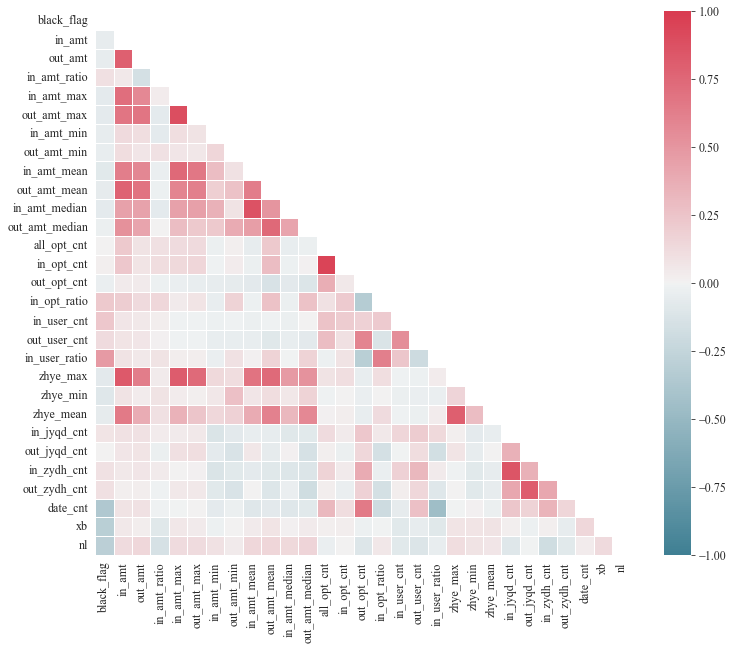

In [35]:
correlationNonFraud = df_feats_v1[df_feats_v1['black_flag'].notnull()].reset_index(drop=True).merge(data_static[keep_cols], on='zhdh').iloc[:,1:].corr()
print(correlationNonFraud.shape)
mask = np.zeros_like(correlationNonFraud)
indices = np.triu_indices_from(correlationNonFraud)
mask[indices] = True

#mask[(correlationNonFraud > -0.5) & (correlationNonFraud < 0.9) ] = True

cmap = sns.diverging_palette(220, 8, as_cmap=True)


plt.rc('font',family='Times New Roman',size=12)
plt.figure(figsize=(12, 10))
sns.heatmap(correlationNonFraud, vmin = -1, vmax = 1, \
    cmap = cmap, square = False, linewidths = 0.5, mask = mask, cbar = True)
plt.show()

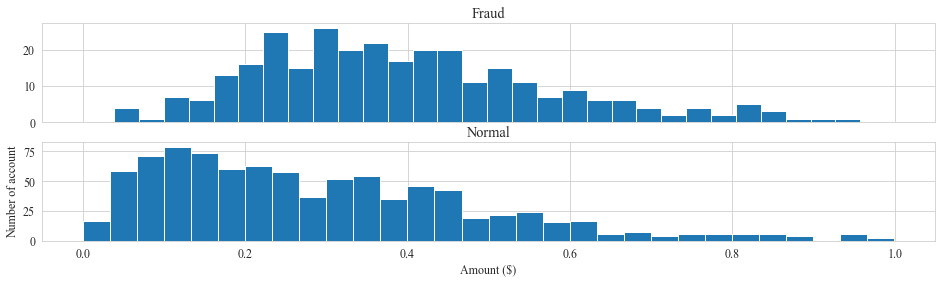

In [36]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16,4))

bins = 30

ax1.hist(df_feats_v1["in_opt_ratio"][df_feats_v1["black_flag"]== 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(df_feats_v1["in_opt_ratio"][df_feats_v1["black_flag"] == 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of account')
#plt.xscale('log')
plt.show()


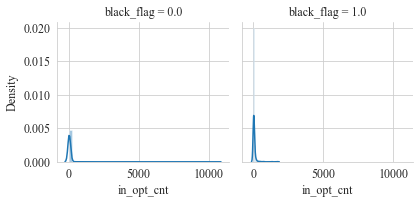

In [37]:
g = sns.FacetGrid(df_feats_v1[df_feats_v1['black_flag'].notnull()], col="black_flag")
g.map(sns.distplot, 'in_opt_cnt')

## 搭建机器学习模型
* 选择合适的模型，初始化可调参数
* 划分训练集和验证集，输入模型开始训练
* 根据模型在验证集上的综合表现，适当的调整参数，或继续进行特征工程

### 选择模型
* `xgboost`
* `lightgbm`
* `catboost`

CatBoost和XGBoost、LightGBM并称为GBDT的三大主流神器，都是在GBDT算法框架下的一种改进实现。XGBoost被广泛的应用于工业界，LightGBM有效的提升了GBDT的计算效率，而Yandex的CatBoost号称是比XGBoost和LightGBM在算法准确率等方面表现更为优秀的算法。

In [38]:
def train_lgb(X_train, y_train, X_val, y_val, X_test, cate_feats=None):

    logging.info(f'#########training lgb....############')

    dtrain = lgb.Dataset(X_train, y_train, categorical_feature=cate_feats)
    dvalid = lgb.Dataset(X_val, y_val, categorical_feature=cate_feats, reference=dtrain)

    params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'min_child_weight': 5,
                'num_leaves': 2 ** 5,
                'lambda_l2': 10,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 4,
                'learning_rate': 0.01,
                'seed': 2020,
                'n_jobs':8
            }
    callbacks = [log_evaluation(period=200), early_stopping(stopping_rounds=200)]#stopping_rounds=30指如果验证集的误差在30次迭代内没有降低，则停止迭代。
    gbm = lgb.train(params, dtrain, 10000, valid_sets=[dtrain, dvalid], 
                            categorical_feature=[], callbacks=callbacks)
        
    val_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)
    
    roc_auc_scores = roc_auc_score(y_val, val_pred)
    print('auc_score:',roc_auc_scores)
    
    test_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
    
    return gbm, test_pred

In [39]:
# 训练lightgbm
def train_lgb_kfold(X_train, y_train, X_test, n_fold=5, cate_feats=None):
    '''train lightgbm with k-fold split'''
    gbms = []
    kfold = StratifiedKFold(n_splits=n_fold, random_state=1024, shuffle=True)
    oof_preds = np.zeros((X_train.shape[0],))
    test_preds = np.zeros((X_test.shape[0],))
    roc_auc_scores = []
    feats = [f for f in X_train.columns]
    feature_importance_df = pd.DataFrame()
    for fold, (train_index, val_index) in enumerate(kfold.split(X_train, y_train)):
        logging.info(f'############ fold {fold} ###########')
        X_tr, X_val, y_tr, y_val = X_train.iloc[train_index], X_train.iloc[val_index], y_train[train_index], y_train[val_index]
        dtrain = lgb.Dataset(X_tr, y_tr, categorical_feature=cate_feats)
        dvalid = lgb.Dataset(X_val, y_val, categorical_feature=cate_feats, reference=dtrain)

        params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'min_child_weight': 5,
                'num_leaves': 2 ** 5,
                'lambda_l2': 10,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 4,
                'learning_rate': 0.01,
                'seed': 2020,
                'n_jobs':8
            }
        callbacks = [log_evaluation(period=200), early_stopping(stopping_rounds=200)]#stopping_rounds=30指如果验证集的误差在30次迭代内没有降低，则停止迭代。
        gbm = lgb.train(params, dtrain, 10000, valid_sets=[dtrain, dvalid], 
                              categorical_feature=[], callbacks=callbacks)
        
        oof_preds[val_index] = gbm.predict(X_val, num_iteration=gbm.best_iteration)
        val_pred = oof_preds[val_index]
        roc_auc_scores.append(roc_auc_score(y_val, val_pred))
        test_preds += gbm.predict(X_test, num_iteration=gbm.best_iteration) / kfold.n_splits
        gbms.append(gbm)
        #记录特征重要性
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = gbm.feature_importance(importance_type='gain')
        fold_importance_df["fold"] = fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    feature_importance_df = feature_importance_df.groupby('feature')['importance'].mean()
    print('Best auc score:{}'.format(max(roc_auc_scores)))

    return gbms, oof_preds, test_preds, feature_importance_df

In [40]:
#训练xgboost
def train_xgb_kfold(X_train, y_train, X_test, n_fold=5):
    '''train xgboost with k-fold split'''
    gbms = []
    kfold = StratifiedKFold(n_splits=n_fold, random_state=1024, shuffle=True)
    oof_preds = np.zeros((X_train.shape[0],))
    test_preds = np.zeros((X_test.shape[0],))
    roc_auc_scores = []
    feature_importance_df = pd.DataFrame()
    for fold, (train_index, val_index) in enumerate(kfold.split(X_train, y_train)):
        logging.info(f'############ fold {fold} ###########')
        X_tr, X_val, y_tr, y_val = X_train.iloc[train_index], X_train.iloc[val_index], y_train[train_index], y_train[val_index]
        train_matrix = xgb.DMatrix(X_tr , label=y_tr)
        valid_matrix = xgb.DMatrix(X_val , label=y_val)
        test_matrix = xgb.DMatrix(X_test)

        params = {
            'booster': 'gbtree',
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'gamma': 1,
            'min_child_weight': 1.5,
            'max_depth': 5,
            'lambda': 10,
            'subsample': 0.7,
            'colsample_bytree': 0.7,
            'colsample_bylevel': 0.7,
            'eta': 0.05,
            'tree_method': 'exact',
            'seed': 2020,
            'nthread': 8
        }
        watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
            
        model = xgb.train(params, train_matrix, num_boost_round=10000,
                          evals=watchlist, verbose_eval=1000, early_stopping_rounds=500)
            
        val_pred  = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
        test_pred = model.predict(test_matrix , ntree_limit=model.best_ntree_limit)
        
        oof_preds[val_index] = val_pred
        test_preds += test_pred / kfold.n_splits
        gbms.append(model)
        roc_auc_scores.append(roc_auc_score(y_val, val_pred))
        #记录特征重要性
        fold_feature_importance = model.get_fscore()
        fold_importance_df = pd.DataFrame()
        fold_importance_df['feature'] = list(fold_feature_importance.keys())
        fold_importance_df['importance'] = list(fold_feature_importance.values())
        fold_importance_df['fold'] = fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    feature_importance_df = feature_importance_df.groupby('feature')['importance'].mean()
    print('Best auc score:{}'.format(max(roc_auc_scores)))
    
    return gbms, oof_preds, test_preds, feature_importance_df

In [41]:
#训练catboost
def train_cat_kfold(X_train, y_train, X_test, n_fold=5):
    '''train catboost with k-fold split'''
    gbms = []
    kfold = StratifiedKFold(n_splits=n_fold, random_state=1024, shuffle=True)
    oof_preds = np.zeros((X_train.shape[0],))
    test_preds = np.zeros((X_test.shape[0],))
    roc_auc_scores = []
    for fold, (train_index, val_index) in enumerate(kfold.split(X_train, y_train)):
        logging.info(f'############ fold {fold} ###########')
        X_tr, X_val, y_tr, y_val = X_train.iloc[train_index], X_train.iloc[val_index], y_train[train_index], y_train[val_index]
        
        model = CatBoostClassifier(
            n_estimators=10000,
            random_seed=1024,
            eval_metric='AUC',
            learning_rate=0.05,
            max_depth=5,
            early_stopping_rounds=200,
            metric_period=500,
        )

        model.fit(X_tr, y_tr, eval_set=(X_val, y_val),
                  use_best_model=True,verbose=1)
        
        val_pred  = model.predict_proba(X_val)[:,1]
        test_pred = model.predict_proba(X_test)[:,1]
        
        oof_preds[val_index] = val_pred
        test_preds += test_pred / kfold.n_splits
        gbms.append(model)
        roc_auc_scores.append(roc_auc_score(y_val, val_pred))
    print('Best auc score:{}'.format(max(roc_auc_scores)))
    return gbms, oof_preds, test_preds

In [42]:
#stacking三种模型训练
def train_stacking_kfold(X_train, y_train, X_test, n_fold=5, cate_feats=None, final_model='lr', stack_method='auto'):
    '''train stacking(lgb,xgb,cat) with k-fold split'''
    gbms = []
    seed = 2020
    kfold = StratifiedKFold(n_splits=n_fold, random_state=1024, shuffle=True)
    oof_preds = np.zeros((X_train.shape[0],))
    test_preds = np.zeros((X_test.shape[0],))
    roc_auc_scores = []
    
    params = dict(
        lgb = {
            'n_estimators': 200,
            'objective': 'binary',
            'learning_rate': 0.05,
            'max_depth':7,
            'num_leaves':63,
            'min_child_samples':20
        },
        xgb = {
            'n_estimators': 200,
            'max_depth': 7,
            'max_leaves': 63,
            'learning_rate': 0.05,
            'booster':'gbtree',
            'subsample': 0.7,
            'colsample_bytree':0.7,
            'reg_alpha':0.1,
            'reg_lambda':0.01,
        },
        cat = {
            'n_estimators': 200,
            'verbose':False,
            'use_best_model':False,
            'learning_rate':0.08,
            'rsm': 0.7,
            'depth': 5,
            'border_count': 32,
            'feature_border_type': 'Median',
        })

    for fold, (train_index, val_index) in enumerate(kfold.split(X_train, y_train)):
        logging.info(f'############ fold {fold} ###########')
        X_tr, X_val, y_tr, y_val = X_train.iloc[train_index], X_train.iloc[val_index], y_train[train_index], y_train[val_index]
        estimators = []

        #定义xgboost分类器
        xgb_model = XGBClassifier(**params['xgb'])
        estimators.append(('xgb', xgb_model))
        #定义lightgbm分类器
        lgb_model = LGBMClassifier(**params['lgb'])
        estimators.append(('lgb', lgb_model))
        #定义catboost分类器
        cat_model = CatBoostClassifier(**params['cat'])
        estimators.append(('cat', cat_model))
        
        if final_model == 'lr':
            final_estimator = LogisticRegression()
        elif final_model == 'mlp':
            final_estimator = MLPClassifier()

        model = StackingClassifier(estimators=estimators, final_estimator=final_estimator, stack_method=stack_method)
        model.fit(X_tr, y_tr)
        
        val_pred  = model.predict_proba(X_val)[:,1]
        test_pred = model.predict_proba(X_test)[:,1]
        
        oof_preds[val_index] = val_pred
        test_preds += test_pred / kfold.n_splits
        gbms.append(model)
        roc_auc_scores.append(roc_auc_score(y_val, val_pred))
    print('Best auc score:{}'.format(max(roc_auc_scores)))
    return gbms, oof_preds, test_preds

### 开始训练

In [43]:
df_1 = pd.merge(df_feats_v1, data_static[keep_cols], on='zhdh', how='left')

In [56]:
test_cst = pd.read_csv('data/test_dataset.csv')
print(test_cst.head())

test_names = test_cst['zhdh'].to_list()
print(test_names[:5])

print(type(test_cst['zhdh'].values))

               zhdh
0  B6751CD225DD4886
1  8265CA869E4AFF16
2  06DD2A17463919FC
3  F36469EA4C5BD7FC
4  A18F7ACD7A3853D1
['B6751CD225DD4886', '8265CA869E4AFF16', '06DD2A17463919FC', 'F36469EA4C5BD7FC', 'A18F7ACD7A3853D1']
<class 'numpy.ndarray'>


In [53]:
df_test = df_1[df_1['zhdh'].isin(test_names)].reset_index(drop=True)
df_test.set_index('zhdh',inplace=True)
df_test = df_test.reindex(test_names).reset_index()
print(df_test.head())
print(df_test.shape[0])

               zhdh  black_flag     in_amt    out_amt  in_amt_ratio  \
0  B6751CD225DD4886         NaN   32413.00   33351.90      0.492862   
1  8265CA869E4AFF16         NaN   34570.69   42239.35      0.450080   
2  06DD2A17463919FC         NaN  398192.92  397825.72      0.500231   
3  F36469EA4C5BD7FC         NaN   34172.11   34172.48      0.499997   
4  A18F7ACD7A3853D1         NaN  139965.93  139541.94      0.500758   

   in_amt_max  out_amt_max  in_amt_min  out_amt_min   in_amt_mean  ...  \
0      8800.0      5601.01      173.00         3.40   5402.166667  ...   
1      9508.0      9400.00        8.80         1.00   1440.445417  ...   
2    155000.0    155000.00        2.02        16.78  26546.194667  ...   
3      6000.0      6000.00       95.46        95.83   3106.555455  ...   
4     40000.0     50000.00      160.00         6.14   7366.627895  ...   

    zhye_max  zhye_min     zhye_mean  in_jyqd_cnt  out_jyqd_cnt  in_zydh_cnt  \
0   10932.66      0.00   4436.520000            

In [67]:
df_train = df_1[df_1.black_flag.notnull()].reset_index(drop = True).iloc[:,1:] #去掉zhdh一列，保留black_flag

#split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1024)

X_train_set,X_val_set = train_test_split(df_train, stratify=df_train['black_flag'],test_size=0.2, random_state=1024)
X_train_set = X_train_set.reset_index(drop=True)
X_val_set = X_val_set.reset_index(drop=True)

X_train,y_train,X_val,y_val = X_train_set.iloc[:,1:],X_train_set.iloc[:,0],X_val_set.iloc[:,1:],X_val_set.iloc[:,0]

X_test = df_test.iloc[:,2:]

g,test_pred = train_lgb(X_train, y_train, X_val, y_val, X_test)

test_result = pd.DataFrame(
    {
        'zhdh':test_cst['zhdh'].values,
        'pred':test_pred
    }
)

[LightGBM] [Info] Number of positive: 240, number of negative: 720
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4797
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.250000 -> initscore=-1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 200 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [69]:
print(test_result)

                  zhdh      pred
0     B6751CD225DD4886  0.033487
1     8265CA869E4AFF16  0.092888
2     06DD2A17463919FC  0.389990
3     F36469EA4C5BD7FC  0.181972
4     A18F7ACD7A3853D1  0.178327
...                ...       ...
4795  5E1C4461BC135745  0.353060
4796  0507C0E6649E637C  0.081804
4797  2CB5C631D0BE5241  0.071355
4798  193FE069CEA9AD06  0.071745
4799  0241065EA111174C  0.094660

[4800 rows x 2 columns]


In [ ]:
#用第一种处理得到的特征进行训练
df_1 = pd.merge(df_feats_v1, data_static[keep_cols], on='zhdh', how='left')

df_train_v1 = df_1[df_1.black_flag.notnull()].reset_index(drop = True)
df_test_v1 = df_1[df_1.black_flag.isnull()].reset_index(drop = True)

feats = df_train_v1.columns[2:].tolist()
X_train_v1 = df_train_v1[feats]
y_train_v1 = df_train_v1['black_flag']
X_test_v1 = df_test_v1[feats]

gbms_v1, oof_preds_v1, test_preds_v1, f_imp_v1 = train_lgb_kfold(X_train_v1, y_train_v1, X_test_v1, n_fold=5)

[LightGBM] [Info] Number of positive: 240, number of negative: 720
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4783
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.250000 -> initscore=-1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 200 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [ ]:
#打印重要性最高的前10个特征名称
k = 10
print('Top{} feature importance:\n'.format(k), f_imp_v1.sort_values(ascending=False).head(k))

Top10 feature importance:
 feature
date_cnt         10895.895254
in_user_cnt       9238.900864
zhye_min          2017.178538
in_amt_min        1759.773787
xb                1560.197668
in_user_ratio     1279.281696
nl                1273.842848
in_amt_median      872.194024
in_amt_ratio       535.106205
out_user_cnt       352.787933
Name: importance, dtype: float64


In [ ]:
g,oof,predict, f_imp = train_xgb_kfold(X_train_v1, y_train_v1, X_test_v1, n_fold=5)

#打印重要性最高的前10个特征名称
k = 10
print('Top{} feature importance:\n'.format(k), f_imp.sort_values(ascending=False).head(k))

[0]	train-auc:0.87056	eval-auc:0.82653
[661]	train-auc:0.99744	eval-auc:0.92583
[0]	train-auc:0.84716	eval-auc:0.83014
[688]	train-auc:0.99773	eval-auc:0.94546
[0]	train-auc:0.86730	eval-auc:0.84065
[687]	train-auc:0.99727	eval-auc:0.94287
[0]	train-auc:0.83887	eval-auc:0.81060
[710]	train-auc:0.99739	eval-auc:0.96361
[0]	train-auc:0.83400	eval-auc:0.75963
[759]	train-auc:0.99780	eval-auc:0.94407
Best auc score:0.9703703703703703
Top10 feature importance:
 feature
date_cnt         314.4
in_user_cnt      210.2
zhye_min         136.4
nl               119.2
in_amt_ratio     106.2
zhye_mean        103.0
in_amt_min       101.0
in_user_ratio    100.8
in_amt_median     90.8
out_user_cnt      87.0
Name: importance, dtype: float64


In [ ]:
g,oof,predict = train_cat_kfold(X_train_v1, y_train_v1, X_test_v1, n_fold=5)

0:	test: 0.8758796	best: 0.8758796 (0)	total: 63.8ms	remaining: 10m 37s
500:	test: 0.9260185	best: 0.9262037 (418)	total: 2.07s	remaining: 39.2s
1000:	test: 0.9284259	best: 0.9291667 (952)	total: 3.91s	remaining: 35.2s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9291666667
bestIteration = 952

Shrink model to first 953 iterations.
0:	test: 0.8592130	best: 0.8592130 (0)	total: 2.69ms	remaining: 26.9s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9590740741
bestIteration = 80

Shrink model to first 81 iterations.
0:	test: 0.8855556	best: 0.8855556 (0)	total: 4.53ms	remaining: 45.3s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9530555556
bestIteration = 274

Shrink model to first 275 iterations.
0:	test: 0.8881481	best: 0.8881481 (0)	total: 3.29ms	remaining: 32.9s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9677777778
bestIteration = 115

Shrink model to first 116 iterations.
0:	test: 0.8139815	best: 0.8139815 (0)	total: 2.8ms	remaining: 28s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9496296296
bestIteration = 83

Shrink model to first 84 iterations.
Best auc score:0.9677777777777777


In [ ]:
g,oof,predict = train_stacking_kfold(X_train_v1, y_train_v1, X_test_v1, n_fold=5)

[LightGBM] [Info] Number of positive: 240, number of negative: 720
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4783
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.250000 -> initscore=-1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [ ]:
#用第二种处理得到的特征进行训练
df_2 = pd.merge(df_feats_v2, data_static[keep_cols], on='zhdh', how='left')


df_train_v2 = df_2[df_2.black_flag.notnull()].reset_index(drop = True)
df_test_v2 = df_2[df_2.black_flag.isnull()].reset_index(drop = True)

feats = df_train_v2.columns[2:].tolist()
X_train_v2 = df_train_v2[feats]
y_train_v2 = df_train_v2['black_flag']
X_test_v2 = df_test_v2[feats]

gbms_v2, oof_preds_v2, test_preds_v2, f_imp_v2 = train_lgb_kfold(X_train_v2, y_train_v2, X_test_v2, n_fold=5)

[LightGBM] [Info] Number of positive: 240, number of negative: 720
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8667
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.250000 -> initscore=-1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 200 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [ ]:
#用第三种处理得到的特征进行训练
df_3 = pd.merge(df_feats_v3, data_static[keep_cols], on='zhdh', how='left')


df_train_v3 = df_3[df_3.black_flag.notnull()].reset_index(drop = True)
df_test_v3 = df_3[df_3.black_flag.isnull()].reset_index(drop = True)

feats = df_train_v3.columns[2:].tolist()
X_train_v3 = df_train_v3[feats]
y_train_v3 = df_train_v3['black_flag']
X_test_v3 = df_test_v3[feats]

gbms_v3, oof_preds_v3, test_preds_v3, f_imp_v3 = train_lgb_kfold(X_train_v3, y_train_v3, X_test_v3, n_fold=5)

[LightGBM] [Info] Number of positive: 240, number of negative: 720
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11023
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.250000 -> initscore=-1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 200 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

## 阈值搜索

对于类别不平衡的分类问题非常重要


In [ ]:
def select_best_threshold(oof, y_true):
    result = pd.DataFrame()

    for threshold in np.arange(0.1, 0.8, 0.02):
        preds = (oof > threshold).astype(int)
        f1 = f1_score(y_true, preds)
        pr = precision_score(y_true, preds)
        rc = recall_score(y_true, preds)
        result = result.append(pd.DataFrame({
            'threshold': [threshold],
            'f1': [f1],
            'recall': [rc],
            'precision': [pr]
        }))

    best_threshold = result.sort_values('f1')['threshold'].iloc[-1]

    return best_threshold, result

In [ ]:
best_threshold_lgb_v1, result_lgb_v1 = select_best_threshold(oof_preds_v1, y_train_v1)
print(best_threshold_lgb_v1)

0.30000000000000004


In [ ]:
test_result_v1 = (test_preds_v1 > best_threshold_lgb_v1).astype(int)

print(len(test_result_v1))

print(test_result_v1[:5])

4800
[0 1 0 0 0]


## 参考
* 开源代码仓库
    * [GoogleLLP_DCIC2023-Fraud-Risk-Identification](https://github.com/GoogleLLP/DCIC2023-Fraud-Risk-Identification)

    * [Uroboros0313_DCIC2023_Fraud_Risk_Detect](https://github.com/Uroboros0313/DCIC2023_Fraud_Risk_Detect)

    * [jiangxiaoshuaiya_2023DCIC](https://github.com/jiangxiaoshuaiya/2023DCIC)

* 博客
    * [构建信用卡反欺诈预测模型——机器学习](https://www.zhihu.com/tardis/zm/art/30461746?source_id=1003)

    * [科技金融欺诈风险识别baseline](https://zhuanlan.zhihu.com/p/605256467)

**ps: 上述代码仓库的链接需要科学上网**